# IFT6269 - Homework 1 - Maximum Likelihood Estimation

**Due**: Thursday, September 26th, 2024

#### Name: Grégoire Barrette
#### Student ID: 20175180
#### Collaborators: None



### Introduction

In this question, we are going to numerically explore the MLE of the variance parameter of the Gaussian  

### Tasks
0.   Get your own copy of this file via "File > Save a copy in Drive...";
1.   Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw1_thomasBayes.ipynb`;
2.   Read the instructions provided on each section and cell carefully;
3.   Implement the missing features for the functions in section **Playground**;
4.   Answer the questions in section **Gaussian Maximum Likelihood Estimation**;
5.   Share your notebook with `ift6269.f24@gmail.com` ("Share" button on the top-right corner);
6.   Share the link of your notebook on Gradescope ("Share > Copy Link", and paste the link in "Homework 1 (Programming & Checklist)" on Gradescope).
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the provided functions! Please add all your new auxiliary functions here.

I will find the MLE estimator for $\mu$ and $\sigma^2$ using Gradient Descent. First, each trial is independently and identically distributed according to a standard normal definition: $X_i\sim \mathcal{N(0,1)}$. So the joint distribution for $n$ trials is
$$p(x_1, \dots, x_n; \mu, \sigma^2) = \prod_{i=1}^n\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}.$$
Usually, we find the MLE by maximizing the $\log$ of $p(x_1,\dots, x_n)$ with respect to the parameters. Here, I will recast this into a minimization problem so I can use gradient descent. This translates to minimizing the negative log-lilkelyhood $\ell(\mu, \sigma^2) = -\log p(x_1,\dots, x_n; \mu, \sigma^2)$. 
\begin{align*}
\ell(\mu, \sigma^2) = -\log p(x_1,\dots, x_n; \mu, \sigma^2) &= -\log\left(\prod_{i=1}^n\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}\right),\\
&= -\sum_{i=1}^n\left(-\frac{1}{2}\log(2\pi\sigma^2) + \log\left(e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}\right)\right),\\
&=\frac{n}{2}\log(2\pi\sigma^2)+\sum_{i=1}^n\frac{1}{2\sigma^2}(x_i-\mu)^2.
\end{align*}

I will need the gradients with respect to the parameters $\mu$ and $\sigma^2$. Let's compute them:
$$\frac{\partial\ell(\mu,\sigma^2)}{\partial\mu} = -\sum_{i=1}^n\frac{x_i-\mu}{\sigma^2},$$
and
$$\frac{\partial\ell(\mu,\sigma^2)}{\partial\sigma^2} = \frac{n}{\sigma} - \sum_{i=1}^n\frac{(x_i-\mu)^2}{\sigma^4}.$$

Then, the gradient descent algorithm proposes a new point $(\mu_{i+1},\,\sigma_{i+1}^2)$ based on the gradient computed at the previous points and the learning rate $\varepsilon$:
$$(\mu_{i+1},\,\sigma_{i+1}^2) = (\mu_i - \varepsilon\frac{\partial\ell(\mu,\sigma^2)}{\partial\mu},\, \sigma_i^2 -\varepsilon\frac{\partial\ell(\mu,\sigma^2)}{\partial\sigma^2}).$$

In [40]:
def sample_gaussian_data(num_samples, num_trials):
    """
    
    Generate num_trials sets of samples of a *standard* 1-d Gaussian random variable.
    Each set of samples contains num_sample samples

        Inputs:
            num_samples: [int] Number of samples to generate per trial
            num_trials: [int] Number of trials to generate

        Returns:
            samples: [num_samples, num_trials] Vector of generated samples
    """

    samples = np.random.normal(0, 1, (num_samples, num_trials))

    return samples

def mu_sigma2_mle(samples):
    """
   
    Compute Gaussian MLE estimators for the mean and variance
        Inputs:
             samples: [num_samples, num_trials] Matrix of N(0, 1) iid samples.
                      It contains num_trials sets, each of these sets containing
                      num_samples samples.

        Returns:
             mu_hat: [num_trials] Vector of MLE mean estimators for each trial
             sigma2_hat: [num_trials] Vector of MLE variance estimators for each trial

    """
    # Useful dimensions
    num_samples, num_trials = samples.shape

    mu_hat = np.zeros(num_trials)
    sigma2_hat = np.zeros(num_trials)

    # gradient descent parameters
    lr = 1e-5 # learning rate
    tol = 1e-6 # tolerance
    max = 100000 # maximum number of iterations

    # initial (educated) guesses for mean and variance 
    mu = 0
    sigma2 = 1
    true_var = np.zeros(num_trials)
    # loop over all trials
    for i in range(num_trials):
        print('True variance is: ', np.var(samples[:,i]))
        true_var[i] = np.var(samples[:,i])
        # gradient descent loop
        step = 0
        for j in range(max):
            # compute the gradients
            grad_mu = -(1 / sigma2**2) * np.sum(samples[:,i] - mu)
            grad_sigma2 = (num_samples / sigma2) - (1 / sigma2**4) * np.sum((samples[:,i] - mu)**2)
        
            # gradient descent step
            new_mu = mu - lr * grad_mu
            new_sigma2 = sigma2 - lr * grad_sigma2

            # ensuring sigma2 is positive
            if new_sigma2 <= 0:
                new_sigma2 = 1e-6

            # check for convergence
            if (np.abs(mu - new_mu) < tol) and (np.abs(sigma2 - new_sigma2) < tol):
                break

            # update to new values
            mu = new_mu
            sigma2 = new_sigma2 
            step += 1
        
        mu_hat[i] = mu
        sigma2_hat[i] = sigma2
        print(sigma2)

        print('Trial ', i+1, ' converged in ', step, ' steps.')

    return mu_hat, sigma2_hat, true_var

def freq_mean_var(x):
    """
    Compute the frequentist mean and variance of a vector of n real numbers
        Inputs:
             x: [n] Vector of real numbers

        Returns:
             (mean, var): [tuple] Frequentist mean and variance of x

    """

    n = x.shape[0]

    mean = (1 / n)*np.sum(x)
    var = (1 / n)*np.sum((x - mean)**2)

    return mean, var

def empirical_frequentist_bias(empirical_mean, true_mean):
    """
    
    Estimate the frequentist bias of an estimator given its empirical and true means
        Inputs:
             true_mean: [float] True mean of the estimator
             empirical_mean: [float] Empirical mean of the estimator

        Returns:
             bias: [float] Frequentist bias

    """

    # computing the bias
    bias = true_mean - empirical_mean

    return bias

def plot_sigma_hat_histogram(samples, bins=200):
    """
    Plots a histogram of a estimated variances
        Inputs:
            samples: [array] Estimated variances to be plotted

    """
    # Plot histogram with custom bins for readability.
    plt.hist(samples, bins=bins, alpha=0.8, label=r'$\hat{\sigma}$' +' histogram');
    plt.ylabel('Counts')
    plt.xlim(0,5)
    plt.xlabel(r'$\hat{\sigma^2}$')
    plt.legend();

## Gaussian Maximum Likelihood Estimation


In this section **DO NOT** change the code in any of the cells, unless explicitly stated. Simply answer the questions in the corresponding text cells after having executed your implementation. If you have respected the signature of the functions above in terms of inputs and outputs, your code should run.

### Sample generation

Use the functions defined above to draw $n=5$ samples from the standard Gaussian distribution, $\mathcal{N}(0,1)$.

In [41]:
NUM_SAMPLES = 5

samples = sample_gaussian_data(num_samples=NUM_SAMPLES, num_trials=1)

print('Generated Gaussian samples')
print(samples)

Generated Gaussian samples
[[ 0.50907118]
 [-0.44353673]
 [-1.13602192]
 [-0.39262345]
 [ 1.50631318]]


### MLE computation
Compute the ML estimate $\hat{\mu}$ for the mean and $\hat{\sigma}^2$ for the variance of the Gaussian, as given in Question 3(d).

In [42]:
mu_hat, sigma2_hat, true = mu_sigma2_mle(samples)

print('MLE mean - variance')
print(mu_hat, sigma2_hat)

True variance is:  0.8338366774019214
0.9472514167790389
Trial  1  converged in  14484  steps.
MLE mean - variance
[0.00467235] [0.94725142]


### MLE computation
Repeat the previous steps 10,000 times.  Plot a histogram of the 10,000 estimates of the Gaussian  variance  parameter  to  show  its  empirical  distribution.

In [44]:
NUM_TRIALS = int(1e3)
samples = sample_gaussian_data(num_samples=NUM_SAMPLES, num_trials=NUM_TRIALS)
_, sigma2_hat_vec, true = mu_sigma2_mle(samples)


True variance is:  2.399753030147962
1.3396027811261066
Trial  1  converged in  100000  steps.
True variance is:  1.3692389390562762
1.111035819383693
Trial  2  converged in  100000  steps.
True variance is:  0.15495594246426364
0.5372344737323805
Trial  3  converged in  34704  steps.
True variance is:  0.13616169038779088
0.5145653361197511
Trial  4  converged in  37086  steps.
True variance is:  1.1189190472382493
1.0385578455421698
Trial  5  converged in  66160  steps.
True variance is:  0.712916801586582
0.896148355839454
Trial  6  converged in  24217  steps.
True variance is:  0.154554019789739
0.536769057265708
Trial  7  converged in  28883  steps.
True variance is:  0.7874323233660812
0.9237677515920208
Trial  8  converged in  85448  steps.
True variance is:  0.5386647191447864
0.8139149958127856
Trial  9  converged in  62678  steps.
True variance is:  1.1906172916410451
1.0603169882071901
Trial  10  converged in  84615  steps.
True variance is:  0.23403585657803302
0.6164091260

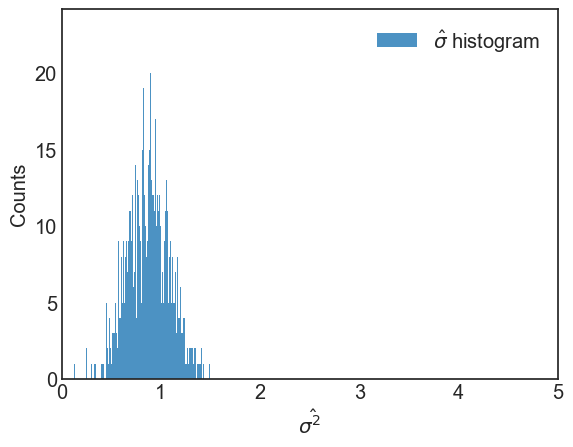

In [38]:
plot_sigma_hat_histogram(sigma2_hat_vec)
for i in range(len(sigma2_hat_vec)):
    if sigma2_hat_vec[i]>10:
        print(sigma2_hat_vec[i])

**Question:** Do you recognize the shape of this histogram? What is it?

**Answer:** Yes, this looks like a Gaussian distribution! Maybe we can explain this result by invoking the central limit theorem.



### Bias and variance of the *estimator*
Use *the same* 10,000 repeated trials to numerically estimate the (frequentist) bias and variance of the ML estimate $\hat{\sigma}^2$ of the Gaussian variance parameter.

Compare the results with the theoretical (frequentist) bias and variance that you can compute from the formula you derived in Question 3(d).

*Hint: if your numerical estimates are very far from the theoretical formula, you made a mistake somewhere!*

In [39]:
sigma2_hat_mean, sigma2_hat_var = freq_mean_var(sigma2_hat_vec)
print(np.mean(sigma2_hat_vec))

TRUE_SIGMA2 = 1.

# In the next lines, fill in the theoretical bias and variance of $\hat{\sigma}^2$
THEO_BIAS = TRUE_SIGMA2 / NUM_TRIALS
THEO_VAR = 2 * TRUE_SIGMA2 * (NUM_TRIALS -1 ) / NUM_TRIALS**2

emp_bias = empirical_frequentist_bias(empirical_mean=sigma2_hat_mean,
                                      true_mean=TRUE_SIGMA2)

print('Theoretical Bias: ', THEO_BIAS, ' Freq. Estimated Bias: ', emp_bias)
print('Theoretical Variance: ', THEO_VAR, ' Freq. Estimated Variance: ', sigma2_hat_var)

0.8778109285961502
Theoretical Bias:  0.001  Freq. Estimated Bias:  0.12218907140384982
Theoretical Variance:  0.001998  Freq. Estimated Variance:  0.04483636983875489


**Question:** What conclusions can you draw from the result of this comparison?

**Answer:**